In [1]:
import sys
import pprint
import os
import numpy as np
import keras
from keras.utils.np_utils import to_categorical
import h5py
import yaml, json
from PIL import Image
%pylab inline
plt.rcParams['image.cmap'] = 'gray'

# get magic root folder
config_path="/work/ds_config.yaml"
with open(config_path) as f:
    configs = yaml.safe_load(f)
sys.path.append(configs['PROJECT_ROOT'])


from data_iters import iam_hdf5_iterator

Populating the interactive namespace from numpy and matplotlib


In [106]:
import theano
theano.config.exception_verbosity='high'
theano.config.optimizer='fast_compile'

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, AutoEncoder
from keras.layers.convolutional import MaxPooling2D, Convolution2D, Convolution1D

from keras.optimizers import SGD, Adam

from seya.attention import SpatialTransformer

In [12]:
#data
nb_authors = 100
nb_forms = 5
shingle_dim = (128,128)
iam_iter = iam_hdf5_iterator.IAM_MiniBatcher("/fileserver/iam/iam-processed/lines/author_lines.hdf5",
                                            nb_authors,
                                            nb_forms,
                                            use_form=True,
                                            shingle_dim=shingle_dim)

In [ ]:
#autoencoder
def simple_autoencoder_layers():
    encoder = Sequential()
    encoder.add(Dense(128, input_dim=np.prod(shingle_dim)))
    #encoder.add(Dense(16))
    decoder = Sequential()
    #decoder.add(Dense(128, input_dim=16))
    decoder.add(Dense(1024, input_dim=128))
    decoder.add(Dense(np.prod(shingle_dim)))

    autoencoder = Sequential([AutoEncoder(encoder, decoder)])

    sgd = SGD(lr=0.9, momentum=0.9)

    autoencoder.compile(loss='rmse', optimizer=sgd)
    return autoencoder

In [ ]:
def plot_example(test_img, input_shape, model):
    test_response = model.predict(test_img, batch_size=1)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(test_img.reshape(*input_shape))
    plt.xlabel('Input')
    plt.subplot(1,2,2)
    plt.imshow(test_response.reshape(*input_shape))
    plt.xlabel('Output')
        
batch_size = 32
total_iters = 5000
autoencoder = simple_autoencoder_layers()
for batch_iter in xrange(total_iters):
    [X_train, Y_train] = iam_iter.get_train_batch(batch_size)
    X_train = X_train.reshape(batch_size, -1)
    #X_train = np.expand_dims(X_train, 1)
    #X_train = randangle(X_train)
    #Y_train = to_categorical(Y_train, num_authors)
    autoencoder.fit(X_train, X_train, batch_size=batch_size, nb_epoch=1, show_accuracy=True, verbose=0)
    
    # plot example
    if  batch_iter % 1000 == 0:
        test_img = X_train[[0],:]
        plot_example(test_img, (128,128), autoencoder)

                   
    

In [107]:
# initial weights
batch_size = 256
epoch_size = 1000

b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

input_shape = (1,128,128)

# from seya's STN demo notebook:
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(4,4), input_shape=input_shape))
locnet.add(Convolution2D(20, 4, 4))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, 4, 4))

locnet.add(Flatten(input_shape=input_shape))
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))

In [108]:
model = Sequential()
model.add(SpatialTransformer(locnet, input_shape=input_shape,downsample_factor=4))
model.add(Convolution2D(32, 4, 4, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(8, 8)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_authors))
model.add(Activation('softmax'))

adam = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=adam)

In [109]:
# allows visualizing STN output
XX = model.get_input()
YY = model.layers[0].get_output()
F = theano.function([XX], YY)

pprint.pprint(locnet.get_config())
pprint.pprint(model.get_config())

{'layers': [{'ignore_border': True,
             'input_shape': (1, 128, 128),
             'name': 'MaxPooling2D',
             'pool_size': (4, 4),
             'stride': (4, 4)},
            {'W_constraint': None,
             'W_regularizer': None,
             'activation': 'linear',
             'activity_regularizer': None,
             'b_constraint': None,
             'b_regularizer': None,
             'border_mode': 'valid',
             'init': 'glorot_uniform',
             'name': 'Convolution2D',
             'nb_col': 4,
             'nb_filter': 20,
             'nb_row': 4,
             'subsample': (1, 1)},
            {'ignore_border': True,
             'name': 'MaxPooling2D',
             'pool_size': (2, 2),
             'stride': (2, 2)},
            {'W_constraint': None,
             'W_regularizer': None,
             'activation': 'linear',
             'activity_regularizer': None,
             'b_constraint': None,
             'b_regularizer': None,
    

----------------------------------------
Epoch: 0 | Train: 0.48828125


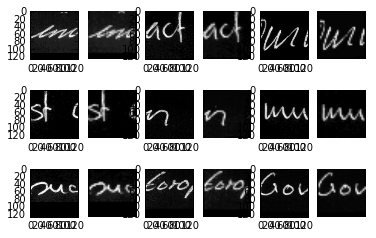

----------------------------------------
Epoch: 1 | Train: 0.71875
----------------------------------------
Epoch: 2 | Train: 0.76171875
----------------------------------------
Epoch: 3 | Train: 0.77734375
----------------------------------------
Epoch: 4 | Train: 0.81640625
----------------------------------------
Epoch: 5 | Train: 0.8359375


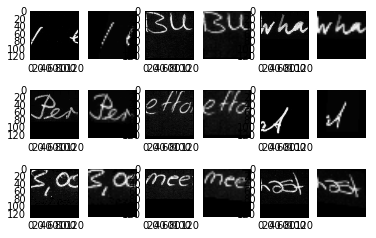

----------------------------------------
Epoch: 6 | Train: 0.796875
----------------------------------------
Epoch: 7 | Train: 0.81640625
----------------------------------------
Epoch: 8 | Train: 0.8671875
----------------------------------------
Epoch: 9 | Train: 0.80078125
----------------------------------------
Epoch: 10 | Train: 0.8671875


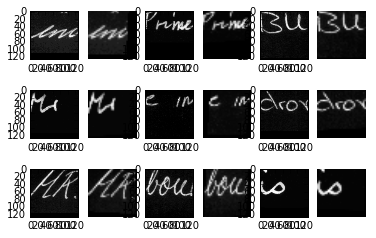

----------------------------------------
Epoch: 11 | Train: 0.83984375
----------------------------------------
Epoch: 12 | Train: 0.81640625
----------------------------------------
Epoch: 13 | Train: 0.81640625
----------------------------------------
Epoch: 14 | Train: 0.81640625
----------------------------------------
Epoch: 15 | Train: 0.859375


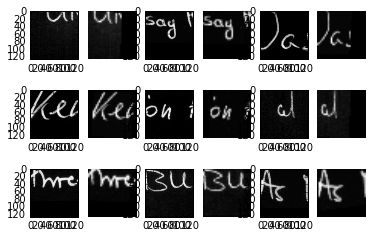

----------------------------------------
Epoch: 16 | Train: 0.8203125
----------------------------------------
Epoch: 17 | Train: 0.81640625
----------------------------------------
Epoch: 18 | Train: 0.8671875
----------------------------------------
Epoch: 19 | Train: 0.80859375
----------------------------------------
Epoch: 20 | Train: 0.75


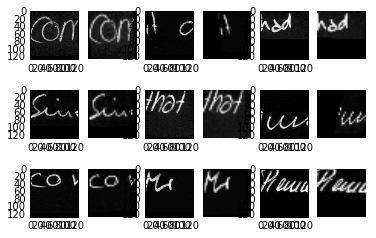

----------------------------------------
Epoch: 21 | Train: 0.80078125
----------------------------------------
Epoch: 22 | Train: 0.81640625
----------------------------------------
Epoch: 23 | Train: 0.78515625
----------------------------------------
Epoch: 24 | Train: 0.85546875
----------------------------------------
Epoch: 25 | Train: 0.8203125


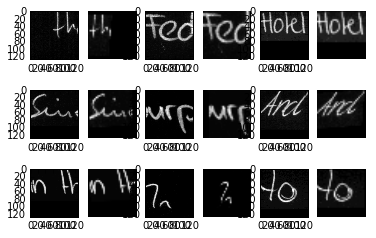

----------------------------------------
Epoch: 26 | Train: 0.8359375
----------------------------------------
Epoch: 27 | Train: 0.8671875
----------------------------------------
Epoch: 28 | Train: 0.83984375
----------------------------------------
Epoch: 29 | Train: 0.828125
----------------------------------------
Epoch: 30 | Train: 0.78125


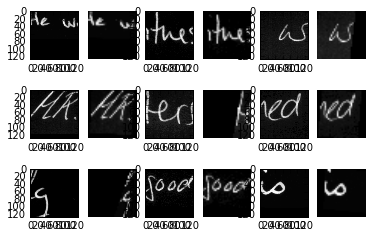

----------------------------------------
Epoch: 31 | Train: 0.796875
----------------------------------------
Epoch: 32 | Train: 0.7890625
----------------------------------------
Epoch: 33 | Train: 0.828125
----------------------------------------
Epoch: 34 | Train: 0.83984375
----------------------------------------
Epoch: 35 | Train: 0.76171875


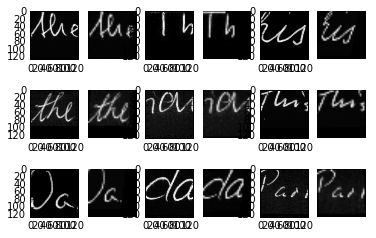

----------------------------------------
Epoch: 36 | Train: 0.86328125
----------------------------------------
Epoch: 37 | Train: 0.79296875
----------------------------------------
Epoch: 38 | Train: 0.84765625
----------------------------------------
Epoch: 39 | Train: 0.78515625
----------------------------------------
Epoch: 40 | Train: 0.8046875


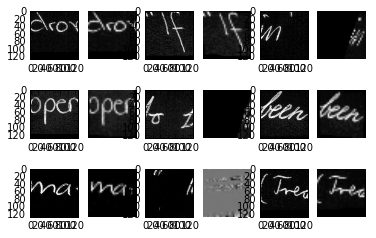

----------------------------------------
Epoch: 41 | Train: 0.8671875
----------------------------------------
Epoch: 42 | Train: 0.8046875
----------------------------------------
Epoch: 43 | Train: 0.82421875
----------------------------------------
Epoch: 44 | Train: 0.84375
----------------------------------------
Epoch: 45 | Train: 0.83203125


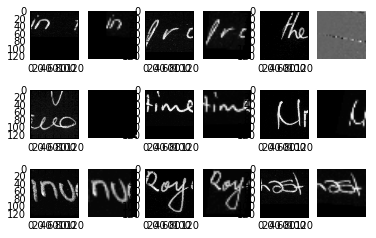

----------------------------------------
Epoch: 46 | Train: 0.8125
----------------------------------------
Epoch: 47 | Train: 0.8515625
----------------------------------------
Epoch: 48 | Train: 0.78125
----------------------------------------
Epoch: 49 | Train: 0.84765625


In [110]:
nb_epochs = 50 # you probably want to go longer than this

fig = plt.figure()
try:
    for e in range(nb_epochs):
        print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(epoch_size):
            f = b * batch_size
            l = (b+1) * batch_size
            [X_batch, y_batch] = iam_iter.get_train_batch(batch_size)
            # add an invisible dimension
            X_batch = np.expand_dims(X_batch, 1).astype('float32')
            y_batch = to_categorical(y_batch, nb_authors).astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scoretr = model.evaluate(X_batch, y_batch, show_accuracy=True, verbose=0)[1]
        #scorev = model.evaluate(X_valid, y_valid, show_accuracy=True, verbose=0)[1]
        #scoret = model.evaluate(X_test, y_test, show_accuracy=True, verbose=0)[1]
        print('Epoch: {0} | Train: {1}'.format(e, scoretr))

        if e % 5 == 0:
            Xresult = F(X_batch[:9])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 6, i*2+1)
                plt.imshow(X_batch[i, 0], cmap='gray')
                plt.subplot(3, 6, i*2+2)
                plt.imshow(Xresult[i, 0], cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
except KeyboardInterrupt:
    pass